<a href="https://colab.research.google.com/github/fabiorfc/Health-Data-Science/blob/master/Heart_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Failure Prediction

## 1) Contextualização

## 2) Preparação do ambiente

### 2.1) Libraries utilizadas

In [ ]:
# Libraries utilizadas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt
from sklearn.model_selection import train_test_split
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Funcoes
def grafico_variaveis_booleanas(tabela, nome_da_variavel, titulo, legenda_da_variavel_booleana, titulo_eixo_x):
    """
      Essa funcao gera dois gráficos de barras para analisar a relacao que o
    obito tem com a variavel booleana
    Os parametros da funcao sao:
      tabela: DataFrame do estudo
      nome_da_variavel: Nome da variavel booleana
      titulo: Titulo do grafico
      legenda_da_variavel_booleana: Legenda da variavel booleana. Primeiro vem o valor 1 depois o 0
    """
    fig, axs = plt.subplots(1,2 , figsize = (10,4))

    cat_01 = tabela.query(nome_da_variavel+" == 1")['Óbito'].value_counts()
    cat_02 = tabela.query(nome_da_variavel+" == 0")['Óbito'].value_counts()

    prop_01 = 100*tabela.query(nome_da_variavel+" == 1")['Óbito'].value_counts()/len(tabela.query(nome_da_variavel+" == 1"))
    prop_02 = 100*tabela.query(nome_da_variavel+" == 0")['Óbito'].value_counts()/len(tabela.query(nome_da_variavel+" == 0"))

    plt.suptitle(titulo, fontsize = 15)
    # Grafico proporcoes empilhado
    axs[0].bar([1,2], [prop_01[0], prop_02[0]], label = 'Óbito = Não')
    axs[0].bar([1,2], [prop_01[1], prop_02[1]], bottom = [prop_01[0], prop_02[0]], label = 'Óbito = Sim')
    axs[0].set_ylim([0,125]);axs[0].set_xticks([1,2])
    axs[0].set_xticklabels(legenda_da_variavel_booleana)
    axs[0].set_ylabel('Proporção (%)', fontsize = 12)
    axs[0].set_xlabel(titulo_eixo_x, fontsize = 12)
    axs[0].legend()

    # Grafico Volume, empilhado
    axs[1].bar([1,2], [cat_01[0], cat_02[0]], label = 'Óbito = Não')
    axs[1].bar([1,2], [cat_01[1], cat_02[1]], bottom = [cat_01[0], cat_02[0]], label = 'Óbito = Sim')
    axs[1].set_xticks([1,2]);axs[1].set_xticklabels(legenda_da_variavel_booleana)
    axs[1].set_xlabel(titulo_eixo_x, fontsize = 12)
    axs[1].set_ylabel('Frequência (#)', fontsize = 12)
    axs[1].legend()

    plt.show()

def transformacao_woe(vetor, y):
    """Funcao para transforma os valores das variaveis booleanas em seus respectivos
    woe. Os parametros dessa funcao sao:
      vetor: Vetor booleanos
      y: Target"""
    # Calculo do woe da variavel
    tabela_cruzada = pd.crosstab(vetor, y)
    proporcao_zero = tabela_cruzada[0]/sum(tabela_cruzada[0])
    proporcao_um = tabela_cruzada[1]/sum(tabela_cruzada[1])
    woe_zero = log(proporcao_zero[0] / proporcao_um[0])
    woe_um = log(proporcao_zero[1] / proporcao_um[1])

    vetor_woe = vetor.map({0 : woe_zero, 1 : woe_um})

    return vetor_woe

def transforma_booleanos_em_woe(X, y, features_booleanas):
    """
        Funcao que seleciona que gera novas colunas com valores de WOE, tendo
    como base valores booleanos. Os parametros da funcao sao:
        X: Vetor de variaveis de entrada
        y: Vetor de variavies de saida
        features_booleanas: Lista com as features booleanas"""
    copia_de_X = X.copy()
    for i in features_booleanas:
        copia_de_X[i+'_woe'] = transformacao_woe(X[i], y)
    return copia_de_X

### 2.2) Leitura dos dados

In [ ]:
dados = pd.read_csv('heart_failure_clinical_records_dataset.csv')
dados.head(2)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1


### 2.3) Tratamento dos dados

In [ ]:
dados.columns
description = ['Age', 
               'Decrease of red blood cells or hemoglobin (boolean)',
               'Level of the CPK enzyme in the blood (mcg/L)',
               'If the patient has diabetes (boolean)',
               'Percentage of blood leaving the heart at each contraction (percentage)',
               'If the patient has hypertension (boolean)',
               'Platelets in the blood (kiloplatelets/mL)',
               'Level of serum creatinine in the blood (mg/dL)',
               'Level of serum sodium in the blood (mEq/L)',
               'Woman or man (binary)',
               'Smoker or not',
               'Time',
               'Death event']

tabela_info = pd.DataFrame({'Colunas' : dados.columns,
                            'Data types' : dados.dtypes,
                            'Descrição' : description})

# Verificação do tipo e descrição dos dados
tabela_info.set_index('Colunas')


,Data types,Descrição
Colunas,,
age,float64,Age
anaemia,int64,Decrease of red blood cells or hemoglobin (boo...
creatinine_phosphokinase,int64,Level of the CPK enzyme in the blood (mcg/L)
diabetes,int64,If the patient has diabetes (boolean)
ejection_fraction,int64,Percentage of blood leaving the heart at each ...
high_blood_pressure,int64,If the patient has hypertension (boolean)
platelets,float64,Platelets in the blood (kiloplatelets/mL)
serum_creatinine,float64,Level of serum creatinine in the blood (mg/dL)
serum_sodium,int64,Level of serum sodium in the blood (mEq/L)


In [ ]:
# Informação geral dos dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
# Criacao da legenda dos dado de Death Event
dados['Óbito'] = dados['DEATH_EVENT'].map({1 : 'Sim', 0 : 'Não'})

dados.head(2)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Óbito
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,Sim
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,Sim


## 3) Análise descritiva dos dados

### 3.1) Death Event

In [ ]:
death_event = pd.DataFrame({'Freq. (#)' : dados['Óbito'].value_counts(),
                            'Freq. (%)' : 100*dados['Óbito'].value_counts()/len(dados)})

death_event.round(decimals = 2)


,Freq. (#),Freq. (%)
Não,203,67.89
Sim,96,32.11


### 3.2) Death Event *versus* Age

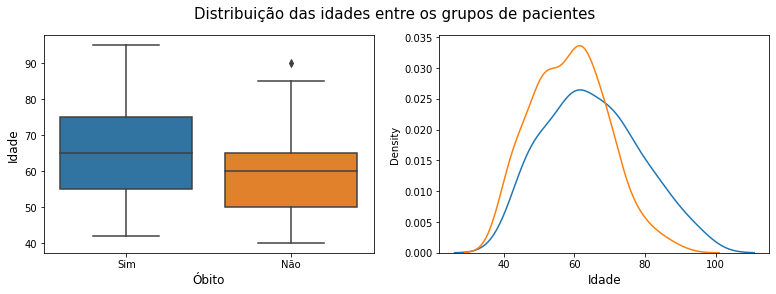

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (13,4))

plt.suptitle('Distribuição das idades entre os grupos de pacientes', fontsize = 15)
sns.boxplot(x = 'Óbito', y = 'age', data = dados, ax = axs[0])
sns.distplot(dados.query('DEATH_EVENT == 1')['age'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.distplot(dados.query('DEATH_EVENT == 0')['age'], ax = axs[1], hist = False, label = 'Óbito: Não')

axs[0].set_ylabel('Idade', fontsize = 12)
axs[0].set_xlabel('Óbito', fontsize = 12)
axs[1].set_xlabel('Idade', fontsize = 12)

plt.show()

### 3.3) Death Event *versus* Anaemia

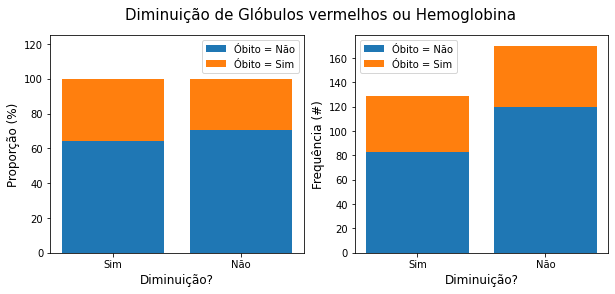

In [ ]:
grafico_variaveis_booleanas(dados, 'anaemia', 'Diminuição de Glóbulos vermelhos ou Hemoglobina',['Sim', 'Não'], 'Diminuição?')

### 3.4) Death Event *versus* creatinine phosphokinase

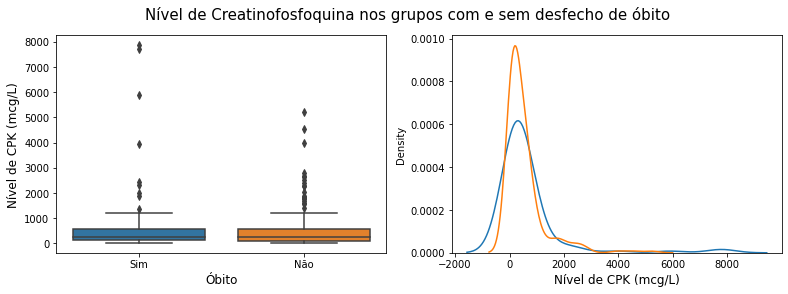

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (13,4))

plt.suptitle('Nível de Creatinofosfoquina nos grupos com e sem desfecho de óbito', fontsize = 15)
sns.boxplot(x = 'Óbito', y = 'creatinine_phosphokinase', data = dados, ax = axs[0])
sns.distplot(dados.query('DEATH_EVENT == 1')['creatinine_phosphokinase'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.distplot(dados.query('DEATH_EVENT == 0')['creatinine_phosphokinase'], ax = axs[1], hist = False, label = 'Óbito: Não')

axs[0].set_ylabel('Nível de CPK (mcg/L)', fontsize = 12)
axs[0].set_xlabel('Óbito', fontsize = 12)
axs[1].set_xlabel('Nível de CPK (mcg/L)', fontsize = 12)

plt.show()

### 3.5) Death event *versus* Diabetes

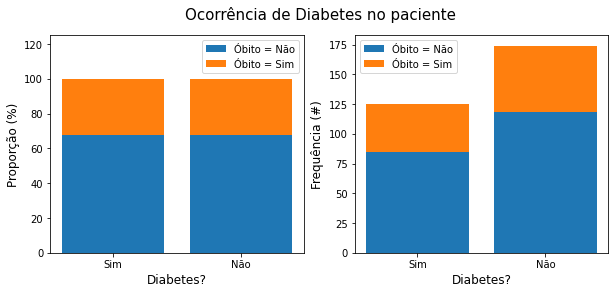

In [ ]:
grafico_variaveis_booleanas(dados, 'diabetes', 'Ocorrência de Diabetes no paciente',['Sim','Não'], 'Diabetes?')

### 3.6) Percentual de Sangue saindo do coração a cada pulsação

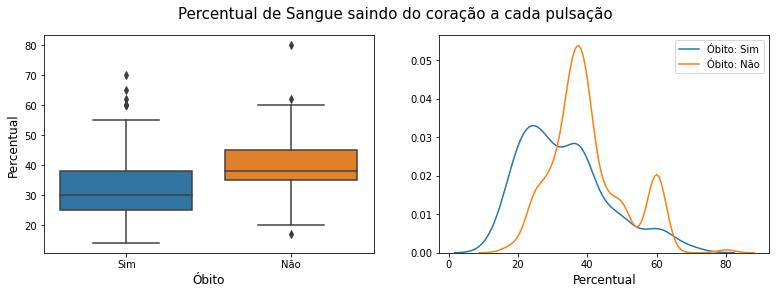

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (13,4))

plt.suptitle('Percentual de Sangue saindo do coração a cada pulsação', fontsize = 15)
sns.boxplot(x = 'Óbito', y = 'ejection_fraction', data = dados, ax = axs[0])
sns.distplot(dados.query('DEATH_EVENT == 1')['ejection_fraction'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.distplot(dados.query('DEATH_EVENT == 0')['ejection_fraction'], ax = axs[1], hist = False, label = 'Óbito: Não')

axs[0].set_ylabel('Percentual', fontsize = 12)
axs[0].set_xlabel('Óbito', fontsize = 12)
axs[1].set_xlabel('Percentual', fontsize = 12)

plt.show()

### 3.7) Hipertensão 

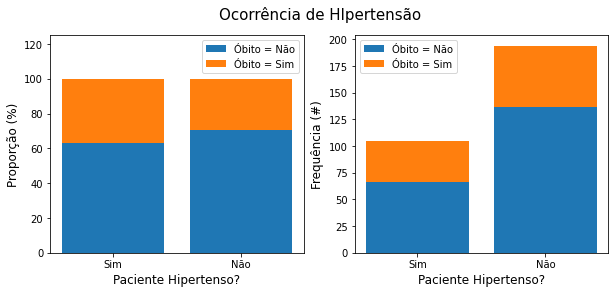

In [ ]:
grafico_variaveis_booleanas(dados, 'high_blood_pressure', 'Ocorrência de HIpertensão',['Sim','Não'], 'Paciente Hipertenso?')

### 3.8) Volume de plaquetas no sangue


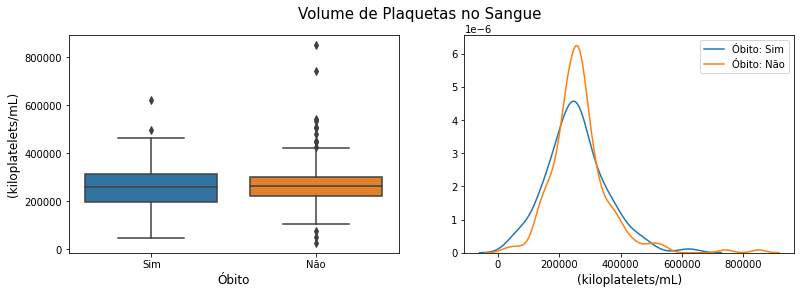

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (13,4))

plt.suptitle('Volume de Plaquetas no Sangue', fontsize = 15)
sns.boxplot(x = 'Óbito', y = 'platelets', data = dados, ax = axs[0])
sns.distplot(dados.query('DEATH_EVENT == 1')['platelets'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.distplot(dados.query('DEATH_EVENT == 0')['platelets'], ax = axs[1], hist = False, label = 'Óbito: Não')

axs[0].set_ylabel('(kiloplatelets/mL)', fontsize = 12)
axs[0].set_xlabel('Óbito', fontsize = 12)
axs[1].set_xlabel('(kiloplatelets/mL)', fontsize = 12)

plt.show()

### 3.9) Nível de creatina sérica no sangue

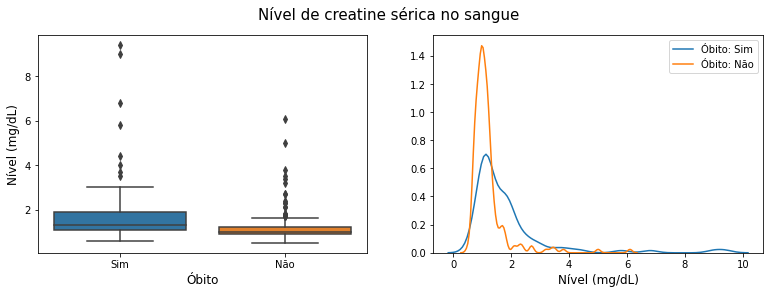

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (13,4))

plt.suptitle('Nível de creatine sérica no sangue', fontsize = 15)
sns.boxplot(x = 'Óbito', y = 'serum_creatinine', data = dados, ax = axs[0])
sns.distplot(dados.query('DEATH_EVENT == 1')['serum_creatinine'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.distplot(dados.query('DEATH_EVENT == 0')['serum_creatinine'], ax = axs[1], hist = False, label = 'Óbito: Não')

axs[0].set_ylabel('Nível (mg/dL)', fontsize = 12)
axs[0].set_xlabel('Óbito', fontsize = 12)
axs[1].set_xlabel('Nível (mg/dL)', fontsize = 12)

plt.show()

### 3.10) Nível de sódio sérico no sangue (mEq / L)

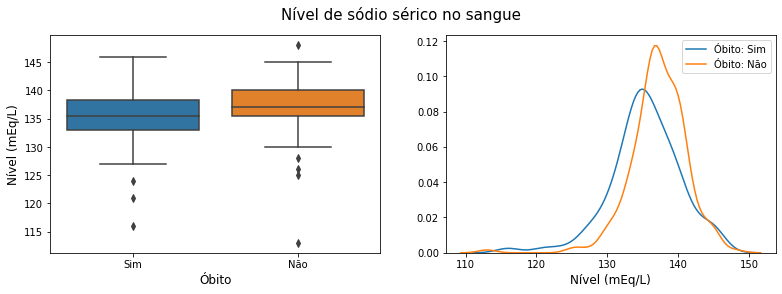

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (13,4))

plt.suptitle('Nível de sódio sérico no sangue', fontsize = 15)
sns.boxplot(x = 'Óbito', y = 'serum_sodium', data = dados, ax = axs[0])
sns.distplot(dados.query('DEATH_EVENT == 1')['serum_sodium'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.distplot(dados.query('DEATH_EVENT == 0')['serum_sodium'], ax = axs[1], hist = False, label = 'Óbito: Não')

axs[0].set_ylabel('Nível (mEq/L)', fontsize = 12)
axs[0].set_xlabel('Óbito', fontsize = 12)
axs[1].set_xlabel('Nível (mEq/L)', fontsize = 12)

plt.show()

### 3.11) Sexo

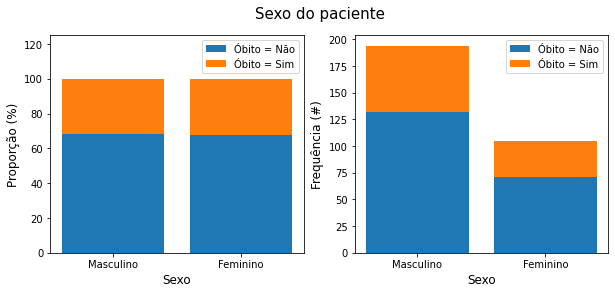

In [ ]:
grafico_variaveis_booleanas(dados, 'sex', 'Sexo do paciente',['Masculino','Feminino'], 'Sexo')

### 3.12) Hábito fumante

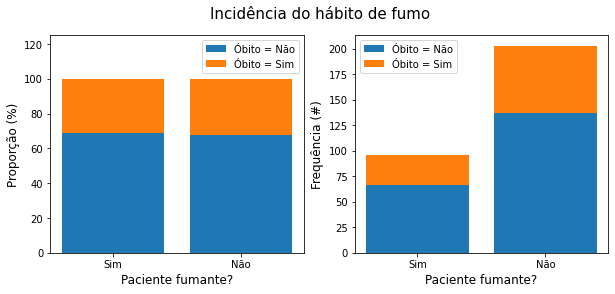

In [ ]:
grafico_variaveis_booleanas(dados, 'smoking', 'Incidência do hábito de fumo',['Sim','Não'], 'Paciente fumante?')

## 4) Ajustando a regressão logística

### 4.1) regressão logística com todas as variáveis


In [ ]:
# Separacao dos dados em variaveis de entrada e saida
y = dados['DEATH_EVENT']
X = dados[['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','anaemia','diabetes','high_blood_pressure','sex','smoking']]

# Separacao em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

# Instanciando a regressao e ajustando o modelo aos dados
regressao_logistica = GLM(y_train, X_train, family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
print(regressao_logistica.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            DEATH_EVENT   No. Observations:                  239
Model:                            GLM   Df Residuals:                      228
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -120.81
Date:                Wed, 30 Sep 2020   Deviance:                       241.62
Time:                        00:19:06   Pearson chi2:                     250.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                     

### 4.2) Refinamento da Regressão logística

In [ ]:
# Separacao dos dados em variaveis de entrada e saida
y = dados['DEATH_EVENT']
X = dados[['age','creatinine_phosphokinase','ejection_fraction','serum_creatinine','serum_sodium']]

# Separacao em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

# Instanciando a regressao e ajustando o modelo aos dados
regressao_logistica = GLM(y_train, X_train, family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
print(regressao_logistica.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            DEATH_EVENT   No. Observations:                  239
Model:                            GLM   Df Residuals:                      234
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.63
Date:                Wed, 30 Sep 2020   Deviance:                       243.25
Time:                        00:19:09   Pearson chi2:                     247.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                     

In [ ]:
# Separacao dos dados em variaveis de entrada e saida
y = dados['DEATH_EVENT']
X = dados[['age','ejection_fraction','serum_creatinine','serum_sodium']]

# Separacao em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

# Instanciando a regressao e ajustando o modelo aos dados
regressao_logistica = GLM(y_train, X_train, family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
print(regressao_logistica.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            DEATH_EVENT   No. Observations:                  239
Model:                            GLM   Df Residuals:                      235
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -122.84
Date:                Wed, 30 Sep 2020   Deviance:                       245.68
Time:                        00:19:19   Pearson chi2:                     247.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                   0.0547      0.01

### 4.2) Definindo threshold para classificar os dados de treino

In [ ]:
# Concatenando os vetores de valores ajustados com valores observados
y_fitted = regressao_logistica.predict(, linear = False)

tabela_de_resultado = pd.DataFrame({'Valores Estimados' : y_fitted, 'Óbito' : y_train})
tabela_de_resultado.head(2)

,Valores Estimados,Óbito
34,0.150224,1
237,0.500317,0


In [ ]:
X_train.corr()

,age,ejection_fraction,serum_creatinine,serum_sodium
age,1.000000,-0.007372,0.178594,-0.054044
ejection_fraction,-0.007372,1.000000,-0.028115,0.196471
serum_creatinine,0.178594,-0.028115,1.000000,-0.255979
serum_sodium,-0.054044,0.196471,-0.255979,1.000000


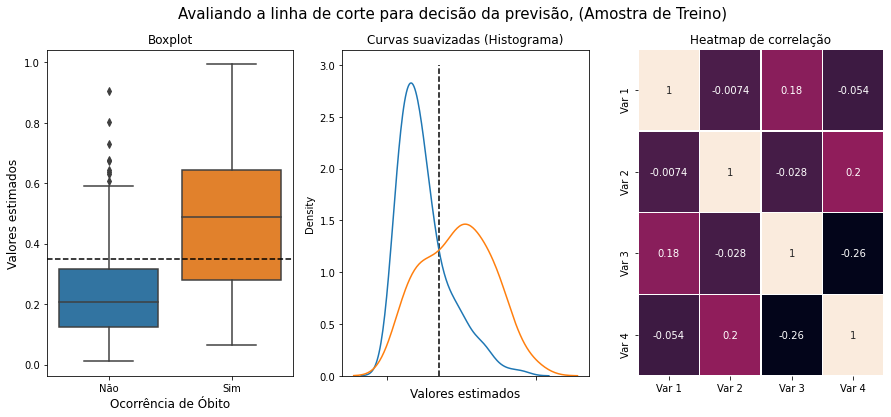

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (15,6))

plt.suptitle('Avaliando a linha de corte para decisão da previsão, (Amostra de Treino)', fontsize = 15)

# Plotando os graficos
sns.boxplot(x = 'Óbito', y = 'Valores Estimados', data = tabela_de_resultado, ax = axs[0])
sns.distplot(tabela_de_resultado.query('Óbito == 0')['Valores Estimados'], ax = axs[1], hist = False, label = 'Óbito: Não', fit_kws={"color":"blue"})
sns.distplot(tabela_de_resultado.query('Óbito == 1')['Valores Estimados'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.heatmap(X_train.corr().values, annot=True, linewidths=0.5, cbar=False, ax = axs[2], xticklabels = ['Var 1','Var 2', 'Var 3', 'Var 4'], yticklabels = ['Var 1','Var 2', 'Var 3', 'Var 4'], cbar_kws={"shrink": .5})
# Edicao dos graficos
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(['Não', 'Sim'])
axs[0].set_xlabel('Ocorrência de Óbito', fontsize = 12)
axs[0].set_ylabel('Valores estimados', fontsize = 12)
axs[0].axhline(y = 0.35, xmin = 0, xmax = 1, linestyle = '--', color = 'black')
axs[0].set_title('Boxplot', fontsize = 12)
axs[1].set_xticks([0,1])
axs[1].set_xticklabels([])
axs[1].set_xlabel('Valores estimados', fontsize = 12)
axs[1].vlines(0.35, 0, 3, linestyles = '--', color = 'black')
axs[1].set_title('Curvas suavizadas (Histograma)', fontsize = 12)
axs[2].set_title('Heatmap de correlação', fontsize = 12)

plt.show()

### 4.3) Avaliando a performance do modelo segundo o threshold definido

In [ ]:
# Concatenando os vetores de valores ajustados com valores observados
y_fitted_test = regressao_logistica.predict(X_test, linear = False)
y_fitted_result = [1 if i >= 0.35 else 0 for i in y_fitted_test]

tabela_de_resultado_final = pd.DataFrame({'Valores Estimados' : y_fitted_test, 'Resposta estimadas' : y_fitted_result, 'Óbito' : y_test})
tabela_de_resultado_final.head(2)

,Valores Estimados,Resposta estimadas,Óbito
222,0.116306,0,0
58,0.332228,0,1


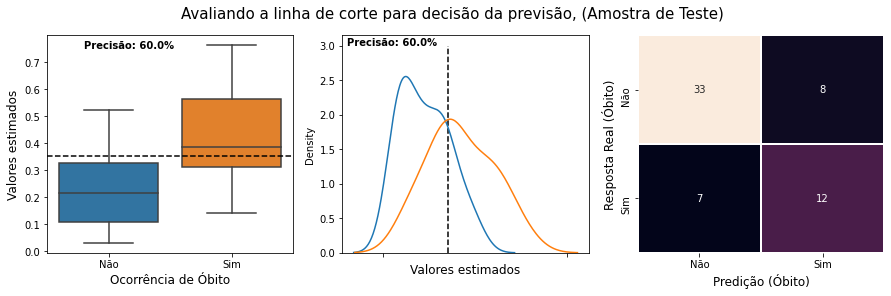

In [ ]:
# Calculo da precisao do modelo na amostra de teste
valor_da_precisao = precision_score(tabela_de_resultado_final['Óbito'], tabela_de_resultado_final['Resposta estimadas'])
valor_da_precisao = str(100*valor_da_precisao)+'%'

# Calculo da matriz de contigencia 
matriz_de_contingencia = confusion_matrix(tabela_de_resultado_final['Óbito'], tabela_de_resultado_final['Resposta estimadas'])

fig, axs = plt.subplots(1,3, figsize = (15,4))

plt.suptitle('Avaliando a linha de corte para decisão da previsão, (Amostra de Teste)', fontsize = 15)

# Plotando os graficos
sns.boxplot(x = 'Óbito', y = 'Valores Estimados', data = tabela_de_resultado_final, ax = axs[0])
sns.distplot(tabela_de_resultado_final.query('Óbito == 0')['Valores Estimados'], ax = axs[1], hist = False, label = 'Óbito: Não', fit_kws={"color":"blue"})
sns.distplot(tabela_de_resultado_final.query('Óbito == 1')['Valores Estimados'], ax = axs[1], hist = False, label = 'Óbito: Sim')
sns.heatmap(matriz_de_contingencia, annot=True, fmt="d", linewidths=0.5, xticklabels = ['Não','Sim'], yticklabels = ['Não','Sim'], cbar=False, ax = axs[2])

# Edicao dos graficos
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(['Não', 'Sim'])
axs[0].set_xlabel('Ocorrência de Óbito', fontsize = 12)
axs[0].set_ylabel('Valores estimados', fontsize = 12)
axs[0].axhline(y = 0.35, xmin = 0, xmax = 1, linestyle = '--', color = 'black')
axs[0].text(-0.2,0.75, 'Precisão: '+ valor_da_precisao , horizontalalignment='left', size='medium', color='black', weight='semibold')
axs[1].text(-0.2,3.00, 'Precisão: '+ valor_da_precisao , horizontalalignment='left', size='medium', color='black', weight='semibold')
axs[1].set_xticks([0,1])
axs[1].set_xticklabels([])
axs[1].set_xlabel('Valores estimados', fontsize = 12)
axs[1].vlines(0.35, 0, 3, linestyles = '--', color = 'black')
axs[2].set_xlabel('Predição (Óbito)', fontsize = 12)
axs[2].set_ylabel('Resposta Real (Óbito)', fontsize = 12)


plt.show()

## 5) Previsão dos dados usando outros algoritmos e metodologias

### 5.1) Processo de enriquecimento dos dados




In [ ]:
# Separacao dos dados (Execução repetida)
y = dados['DEATH_EVENT']
X = dados[['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','anaemia','diabetes','high_blood_pressure','sex','smoking']]

In [ ]:
# Lista com o nome das features de natureza booleana
features_booleanas = ['anaemia','diabetes','high_blood_pressure','sex','smoking']

# Dicionarios de hyperparametros
knn_hyper_paramentros = {'n_neighbors' : [3,5,7], 'weights' : ('uniform', 'distance')}
gbc_hyper_paramentros = {'loss' : ('deviance','exponential'), 'n_estimators' : [100, 150,200]}

# instanciando o particionador de dados
SKfold = StratifiedKFold(n_splits = 3)

# Vetores de performance
resultado_knn = []
resultado_gbc = []
resultado_log = []

contador,limite = 1, 20
while contador < limite:
    print(f'Iteração: {contador} de {limite}')

    rodada, total_rodadas = 1, 3
    for train_index, test_index in SKfold.split(X, y):
        print(f'--- Rodada {rodada} de {total_rodadas}')
        # Separacao dos dados em treinamento e teste
        X_train, X_teste = X.iloc[train_index], X.iloc[test_index]
        y_train, y_teste = y[train_index], y[test_index]

        # Adicionando os valores de woe e retirando os dados booleanos
        X_train = transforma_booleanos_em_woe(X_train, y_train, features_booleanas)
        X_teste = transforma_booleanos_em_woe(X_teste, y_teste, features_booleanas)
        X_train.drop(features_booleanas, axis = 1, inplace = True)
        X_teste.drop(features_booleanas, axis = 1, inplace = True)

        # Normalizando os dados
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_teste = scaler.fit_transform(X_teste)

        # Instanciando os modelos
        knn_clf = GridSearchCV(KNeighborsClassifier(), knn_hyper_paramentros)
        gbc_clf = GridSearchCV(GradientBoostingClassifier(), gbc_hyper_paramentros)
        log_clf = LogisticRegression()

        # Treinando os modelo
        knn_clf.fit(X_train, y_train)
        gbc_clf.fit(X_train, y_train)
        log_clf.fit(X_train, y_train)

        # Extraindo o resultado dos modelos
        knn_precision = round(100*precision_score(y_teste, knn_clf.predict(X_teste)), 1)
        gbc_precision = round(100*precision_score(y_teste, gbc_clf.predict(X_teste)), 1)
        log_precision = round(100*precision_score(y_teste, log_clf.predict(X_teste)), 1)

        # Salvando os resultados
        resultado_knn.append(knn_precision)
        resultado_gbc.append(gbc_precision)
        resultado_log.append(log_precision)

        # Reportando os resultados
        print(f'----- Precisão do KNN: {knn_precision}%')
        print(f'----- Precisão do GBC: {gbc_precision}%')
        print(f'----- Precisão do LOG: {log_precision}%')
        rodada += 1
    contador += 1


Iteração: 1 de 20
--- Rodada 1 de 3
----- Precisão do KNN: 72.7%
----- Precisão do GBC: 51.6%
----- Precisão do LOG: 60.7%
--- Rodada 2 de 3
----- Precisão do KNN: 45.0%
----- Precisão do GBC: 57.1%
----- Precisão do LOG: 55.0%
--- Rodada 3 de 3
----- Precisão do KNN: 64.7%
----- Precisão do GBC: 73.3%
----- Precisão do LOG: 75.0%
Iteração: 2 de 20
--- Rodada 1 de 3
----- Precisão do KNN: 72.7%
----- Precisão do GBC: 51.6%
----- Precisão do LOG: 60.7%
--- Rodada 2 de 3
----- Precisão do KNN: 45.0%
----- Precisão do GBC: 57.1%
----- Precisão do LOG: 55.0%
--- Rodada 3 de 3
----- Precisão do KNN: 64.7%
----- Precisão do GBC: 70.6%
----- Precisão do LOG: 75.0%
Iteração: 3 de 20
--- Rodada 1 de 3
----- Precisão do KNN: 72.7%
----- Precisão do GBC: 51.6%
----- Precisão do LOG: 60.7%
--- Rodada 2 de 3
----- Precisão do KNN: 45.0%
----- Precisão do GBC: 56.0%
----- Precisão do LOG: 55.0%
--- Rodada 3 de 3
----- Precisão do KNN: 64.7%
----- Precisão do GBC: 60.0%
----- Precisão do LOG: 75.0%
I

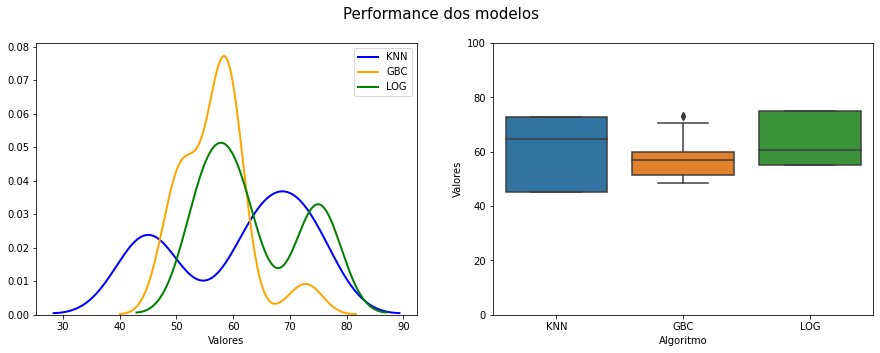

In [ ]:
# Edicao e concatenacao dos resultados
knn_df = pd.DataFrame({'Valores':resultado_knn, 'Algoritmo':['KNN' for i in resultado_knn]})
gbc_df = pd.DataFrame({'Valores':resultado_gbc, 'Algoritmo':['GBC' for i in resultado_gbc]} )
log_df = pd.DataFrame({'Valores':resultado_log, 'Algoritmo':['LOG' for i in resultado_log]} )
tabela_final = pd.concat([knn_df, gbc_df, log_df], axis = 0)

# Grafico
fig, axs = plt.subplots(1, 2, figsize = (15,5))

# Plot dos graficos
sns.distplot(tabela_final.query("Algoritmo == 'KNN'")['Valores'], hist=False, color = 'blue'  , label = 'KNN', ax = axs[0], kde_kws=dict(linewidth=2))
sns.distplot(tabela_final.query("Algoritmo == 'GBC'")['Valores'], hist=False, color = 'orange' , label = 'GBC', ax = axs[0], kde_kws=dict(linewidth=2))
sns.distplot(tabela_final.query("Algoritmo == 'LOG'")['Valores'], hist=False, color = 'green', label = 'LOG', ax = axs[0], kde_kws=dict(linewidth=2))
sns.boxplot(x = 'Algoritmo', y = 'Valores', data = tabela_final, ax = axs[1])

# Edicao dos graficos
plt.suptitle('Performance dos modelos', fontsize = 15)
axs[1].set_ylim([0,100])
plt.show()

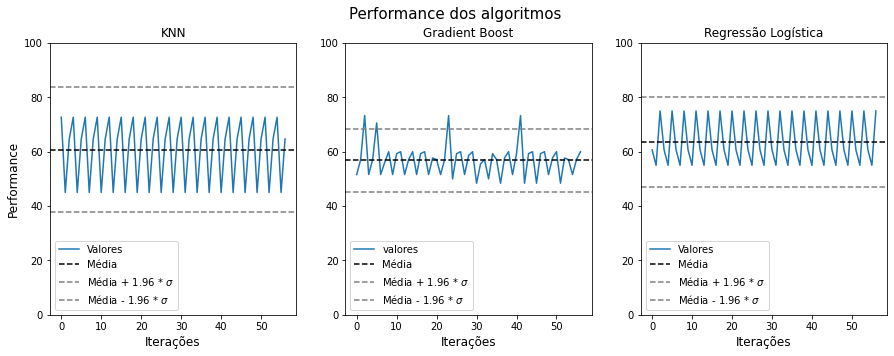

In [ ]:
# Edicao e concatenacao dos resultados
knn_df = pd.DataFrame({'Valores':resultado_knn, 'Algoritmo':['KNN' for i in resultado_knn]})
gbc_df = pd.DataFrame({'Valores':resultado_gbc, 'Algoritmo':['GBC' for i in resultado_gbc]} )
log_df = pd.DataFrame({'Valores':resultado_log, 'Algoritmo':['LOG' for i in resultado_log]} )

# Grafico
fig, axs = plt.subplots(1, 3, figsize = (15,5))

# Plot dos graficos
axs[0].plot(knn_df['Valores'], label = 'Valores')
axs[0].axhline(y = knn_df['Valores'].mean(), xmin = 0, xmax = 1, linestyle = '--', color = 'black', label = 'Média')
axs[0].axhline(y = knn_df['Valores'].mean() + 1.96 * knn_df['Valores'].std(), xmin = 0, xmax = 1, linestyle = '--', color = 'grey', label = 'Média + 1.96 * $\sigma$')
axs[0].axhline(y = knn_df['Valores'].mean() - 1.96 * knn_df['Valores'].std(), xmin = 0, xmax = 1, linestyle = '--', color = 'grey', label = 'Média - 1.96 * $\sigma$')
axs[0].legend(fontsize = 10)

axs[1].plot(gbc_df['Valores'], label = 'valores')
axs[1].axhline(y = gbc_df['Valores'].mean(), xmin = 0, xmax = 1, linestyle = '--', color = 'black', label = 'Média')
axs[1].axhline(y = gbc_df['Valores'].mean() + 1.96 * gbc_df['Valores'].std(), xmin = 0, xmax = 1, linestyle = '--', color = 'grey', label = 'Média + 1.96 * $\sigma$')
axs[1].axhline(y = gbc_df['Valores'].mean() - 1.96 * gbc_df['Valores'].std(), xmin = 0, xmax = 1, linestyle = '--', color = 'grey', label = 'Média - 1.96 * $\sigma$')
axs[1].legend(fontsize = 10)

axs[2].plot(log_df['Valores'], label = 'Valores')
axs[2].axhline(y = log_df['Valores'].mean(), xmin = 0, xmax = 1, linestyle = '--', color = 'black', label = 'Média')
axs[2].axhline(y = log_df['Valores'].mean() + 1.96 * log_df['Valores'].std(), xmin = 0, xmax = 1, linestyle = '--', color = 'grey', label = 'Média + 1.96 * $\sigma$')
axs[2].axhline(y = log_df['Valores'].mean() - 1.96 * log_df['Valores'].std(), xmin = 0, xmax = 1, linestyle = '--', color = 'grey', label = 'Média - 1.96 * $\sigma$')
axs[2].legend(fontsize = 10)

fig.suptitle('Performance dos algoritmos', fontsize = 15)
axs[0].set_ylim([0,100])
axs[0].set_title('KNN', fontsize = 12)
axs[0].set_ylabel('Performance', fontsize = 12)
axs[0].set_xlabel('Iterações', fontsize = 12)
axs[1].set_ylim([0,100])
axs[1].set_title('Gradient Boost', fontsize = 12)
axs[1].set_xlabel('Iterações', fontsize = 12)
axs[2].set_ylim([0,100])
axs[2].set_title('Regressão Logística', fontsize = 12)
axs[2].set_xlabel('Iterações', fontsize = 12)

plt.show()